In [1]:
import gc
import time
import xgboost
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from __future__ import division

from subprocess import check_output
print(check_output(["ls", "input"]).decode("utf8"))
path = '/Users/shaolongchen/Data Science/Kaggle/Instacart/input/'

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



/Users/shaolongchen/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
class tick_tock:
    def __init__(self, process_name, verbose=1):
        self.process_name = process_name
        self.verbose = verbose
    def __enter__(self):
        if self.verbose:
            print(self.process_name + " begin ......")
            self.begin_time = time.time()
    def __exit__(self, type, value, traceback):
        if self.verbose:
            end_time = time.time()
            print(self.process_name + " end ......")
            print('time lapsing {0} s \n'.format(end_time - self.begin_time))
            
def ka_add_groupby_features_1_vs_n(df, group_columns_list, agg_dict, only_new_feature=True):
    '''Create statistical columns, group by [N columns] and compute stats on [N column]

       Parameters
       ----------
       df: pandas dataframe
          Features matrix
       group_columns_list: list_like
          List of columns you want to group with, could be multiple columns
       agg_dict: python dictionary

       Return
       ------
       new pandas dataframe with original columns and new added columns

       Example
       -------
       {real_column_name: {your_specified_new_column_name : method}}
       agg_dict = {'user_id':{'prod_tot_cnts':'count'},
                   'reordered':{'reorder_tot_cnts_of_this_prod':'sum'},
                   'user_buy_product_times': {'prod_order_once':lambda x: sum(x==1),
                                              'prod_order_more_than_once':lambda x: sum(x==2)}}
       ka_add_stats_features_1_vs_n(train, ['product_id'], agg_dict)
    '''
    with tick_tock("add stats features"):
        try:
            if type(group_columns_list) == list:
                pass
            else:
                raise TypeError(k + "should be a list")
        except TypeError as e:
            print(e)
            raise

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped.agg(agg_dict)
        the_stats.columns = the_stats.columns.droplevel(0)
        the_stats.reset_index(inplace=True)
        if only_new_feature:
            df_new = the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')

    return df_new

def ka_add_groupby_features_n_vs_1(df, group_columns_list, target_columns_list, methods_list, keep_only_stats=True, verbose=1):
    '''Create statistical columns, group by [N columns] and compute stats on [1 column]

       Parameters
       ----------
       df: pandas dataframe
          Features matrix
       group_columns_list: list_like
          List of columns you want to group with, could be multiple columns
       target_columns_list: list_like
          column you want to compute stats, need to be a list with only one element
       methods_list: list_like
          methods that you want to use, all methods that supported by groupby in Pandas

       Return
       ------
       new pandas dataframe with original columns and new added columns

       Example
       -------
       ka_add_stats_features_n_vs_1(train, group_columns_list=['x0'], target_columns_list=['x10'])
    '''
    with tick_tock("add stats features", verbose):
        dicts = {"group_columns_list": group_columns_list , "target_columns_list": target_columns_list, "methods_list" :methods_list}

        for k, v in dicts.items():
            try:
                if type(v) == list:
                    pass
                else:
                    raise TypeError(k + "should be a list")
            except TypeError as e:
                print(e)
                raise

        grouped_name = ''.join(group_columns_list)
        target_name = ''.join(target_columns_list)
        combine_name = [[grouped_name] + [method_name] + [target_name] for method_name in methods_list]

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped[target_name].agg(methods_list).reset_index()
        the_stats.columns = [grouped_name] + \
                            ['_%s_%s_by_%s' % (grouped_name, method_name, target_name) \
                             for (grouped_name, method_name, target_name) in combine_name]
        if keep_only_stats:
            return the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')
        return df_new

In [3]:
sample_submission0 = pd.read_csv(path + "sample_submission.csv")
sample_submission = sample_submission0.copy()
print 'sample_submission.shape  (%s, %s)' % sample_submission.shape
sample_submission.head()

sample_submission.shape  (75000, 2)


,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


In [4]:
data = pd.read_csv("data.csv")
print data.shape
data.head()

(13307953, 27)


,user_id,product_id,user_buy_this_product_median_cart_position,user_buy_this_product_last_order_number,user_buy_this_product_total_times,user_buy_this_product_first_order_number,total_No_of_user_buy_this_product,total_No_of_user_buy_this_product_more_than_twice,product_total_order_times,product_total_reorder_times,...,user_distinct_ordered_products,user_reorder_ratio,user_average_basket,order_id,eval_set,time_since_last_order,user_buy_this_product_order_rate,user_buy_this_product_since_last_order,user_buy_this_product_order_rate_since_first_order,reordered
0,1,196,1.0,10,10,1,8000,4660,35791,27791.0,...,18,0.759259,5.9,1187899,train,14.0,1.0,0,1.000000,1.0
1,1,10258,3.0,10,9,2,557,308,1946,1389.0,...,18,0.759259,5.9,1187899,train,14.0,0.9,0,1.000000,1.0
2,1,10326,5.0,5,1,5,1923,1003,5526,3603.0,...,18,0.759259,5.9,1187899,train,14.0,0.1,5,0.166667,NaN
3,1,12427,2.5,10,10,1,1679,889,6476,4797.0,...,18,0.759259,5.9,1187899,train,14.0,1.0,0,1.000000,NaN
4,1,13032,6.0,10,3,2,1286,617,3751,2465.0,...,18,0.759259,5.9,1187899,train,14.0,0.3,0,0.333333,1.0


In [5]:
# train the data
train = data.loc[data.eval_set == "train",:]
print train.shape
train.head()

(8474661, 27)


,user_id,product_id,user_buy_this_product_median_cart_position,user_buy_this_product_last_order_number,user_buy_this_product_total_times,user_buy_this_product_first_order_number,total_No_of_user_buy_this_product,total_No_of_user_buy_this_product_more_than_twice,product_total_order_times,product_total_reorder_times,...,user_distinct_ordered_products,user_reorder_ratio,user_average_basket,order_id,eval_set,time_since_last_order,user_buy_this_product_order_rate,user_buy_this_product_since_last_order,user_buy_this_product_order_rate_since_first_order,reordered
0,1,196,1.0,10,10,1,8000,4660,35791,27791.0,...,18,0.759259,5.9,1187899,train,14.0,1.0,0,1.000000,1.0
1,1,10258,3.0,10,9,2,557,308,1946,1389.0,...,18,0.759259,5.9,1187899,train,14.0,0.9,0,1.000000,1.0
2,1,10326,5.0,5,1,5,1923,1003,5526,3603.0,...,18,0.759259,5.9,1187899,train,14.0,0.1,5,0.166667,NaN
3,1,12427,2.5,10,10,1,1679,889,6476,4797.0,...,18,0.759259,5.9,1187899,train,14.0,1.0,0,1.000000,NaN
4,1,13032,6.0,10,3,2,1286,617,3751,2465.0,...,18,0.759259,5.9,1187899,train,14.0,0.3,0,0.333333,1.0


In [6]:
# run once only
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
print train.shape
train.head()

(8474661, 23)


/Users/shaolongchen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,user_buy_this_product_median_cart_position,user_buy_this_product_last_order_number,user_buy_this_product_total_times,user_buy_this_product_first_order_number,total_No_of_user_buy_this_product,total_No_of_user_buy_this_product_more_than_twice,product_total_order_times,product_total_reorder_times,product_reorder_probability,product_reorder_ratio,...,user_total_order_times,user_total_ordered_products,user_distinct_ordered_products,user_reorder_ratio,user_average_basket,time_since_last_order,user_buy_this_product_order_rate,user_buy_this_product_since_last_order,user_buy_this_product_order_rate_since_first_order,reordered
0,1.0,10,10,1,8000,4660,35791,27791.0,0.582500,0.776480,...,10,59,18,0.759259,5.9,14.0,1.0,0,1.000000,1.0
1,3.0,10,9,2,557,308,1946,1389.0,0.552962,0.713772,...,10,59,18,0.759259,5.9,14.0,0.9,0,1.000000,1.0
2,5.0,5,1,5,1923,1003,5526,3603.0,0.521581,0.652009,...,10,59,18,0.759259,5.9,14.0,0.1,5,0.166667,NaN
3,2.5,10,10,1,1679,889,6476,4797.0,0.529482,0.740735,...,10,59,18,0.759259,5.9,14.0,1.0,0,1.000000,NaN
4,6.0,10,3,2,1286,617,3751,2465.0,0.479782,0.657158,...,10,59,18,0.759259,5.9,14.0,0.3,0,0.333333,1.0


In [7]:
train.loc[:, 'reordered'] = train.reordered.fillna(0)
print train.shape
train.head()

(8474661, 23)


/Users/shaolongchen/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,user_buy_this_product_median_cart_position,user_buy_this_product_last_order_number,user_buy_this_product_total_times,user_buy_this_product_first_order_number,total_No_of_user_buy_this_product,total_No_of_user_buy_this_product_more_than_twice,product_total_order_times,product_total_reorder_times,product_reorder_probability,product_reorder_ratio,...,user_total_order_times,user_total_ordered_products,user_distinct_ordered_products,user_reorder_ratio,user_average_basket,time_since_last_order,user_buy_this_product_order_rate,user_buy_this_product_since_last_order,user_buy_this_product_order_rate_since_first_order,reordered
0,1.0,10,10,1,8000,4660,35791,27791.0,0.582500,0.776480,...,10,59,18,0.759259,5.9,14.0,1.0,0,1.000000,1.0
1,3.0,10,9,2,557,308,1946,1389.0,0.552962,0.713772,...,10,59,18,0.759259,5.9,14.0,0.9,0,1.000000,1.0
2,5.0,5,1,5,1923,1003,5526,3603.0,0.521581,0.652009,...,10,59,18,0.759259,5.9,14.0,0.1,5,0.166667,0.0
3,2.5,10,10,1,1679,889,6476,4797.0,0.529482,0.740735,...,10,59,18,0.759259,5.9,14.0,1.0,0,1.000000,0.0
4,6.0,10,3,2,1286,617,3751,2465.0,0.479782,0.657158,...,10,59,18,0.759259,5.9,14.0,0.3,0,0.333333,1.0


In [8]:
X_test = data.loc[data.eval_set == "test",:]
print X_test.shape
X_test.head()

(4833292, 27)


,user_id,product_id,user_buy_this_product_median_cart_position,user_buy_this_product_last_order_number,user_buy_this_product_total_times,user_buy_this_product_first_order_number,total_No_of_user_buy_this_product,total_No_of_user_buy_this_product_more_than_twice,product_total_order_times,product_total_reorder_times,...,user_distinct_ordered_products,user_reorder_ratio,user_average_basket,order_id,eval_set,time_since_last_order,user_buy_this_product_order_rate,user_buy_this_product_since_last_order,user_buy_this_product_order_rate_since_first_order,reordered
18,15,196,1.0,22,5,15,8000,4660,35791,27791.0,...,13,0.867647,3.272727,2161313,test,7.0,0.227273,0,0.625000,NaN
19,15,12427,2.0,20,10,1,1679,889,6476,4797.0,...,13,0.867647,3.272727,2161313,test,7.0,0.454545,2,0.454545,NaN
20,15,1747,3.5,19,4,8,562,221,1448,886.0,...,13,0.867647,3.272727,2161313,test,7.0,0.181818,3,0.266667,NaN
21,15,10441,2.5,22,8,1,867,465,2909,2042.0,...,13,0.867647,3.272727,2161313,test,7.0,0.363636,0,0.363636,NaN
22,15,11266,1.0,19,10,1,1081,645,4081,3000.0,...,13,0.867647,3.272727,2161313,test,7.0,0.454545,3,0.454545,NaN


In [9]:
test_size = 0.9

In [10]:
# subsample 让training时间更短
X_train, X_val, y_train, y_val = train_test_split(train.drop('reordered', axis=1), train.reordered,
                                                    test_size=test_size, random_state=42)
print X_train.shape
print X_val.shape
print y_train.shape
print y_val.shape

(847466, 22)
(7627195, 22)
(847466,)
(7627195,)


In [11]:
X_train.head()

,user_buy_this_product_median_cart_position,user_buy_this_product_last_order_number,user_buy_this_product_total_times,user_buy_this_product_first_order_number,total_No_of_user_buy_this_product,total_No_of_user_buy_this_product_more_than_twice,product_total_order_times,product_total_reorder_times,product_reorder_probability,product_reorder_ratio,...,user_sum_days_since_prior_order,user_total_order_times,user_total_ordered_products,user_distinct_ordered_products,user_reorder_ratio,user_average_basket,time_since_last_order,user_buy_this_product_order_rate,user_buy_this_product_since_last_order,user_buy_this_product_order_rate_since_first_order
2785200,31.0,8,1,8,1616,305,2145,529.0,0.188738,0.246620,...,355.0,42,1062,370,0.668599,25.285714,6.0,0.023810,34,0.028571
5090964,23.0,22,5,1,19653,8945,45530,25877.0,0.455147,0.568351,...,292.0,23,593,159,0.794872,25.782609,7.0,0.217391,1,0.217391
792885,20.0,12,1,12,3057,1063,5712,2655.0,0.347727,0.464811,...,226.0,21,365,168,0.548747,17.380952,7.0,0.047619,9,0.100000
13078912,2.0,4,2,3,598,233,1208,610.0,0.389632,0.504967,...,60.0,4,19,14,0.416667,4.750000,30.0,0.500000,0,1.000000
7103231,3.0,32,4,7,1035,504,3076,2041.0,0.486957,0.663524,...,331.0,34,409,171,0.608696,12.029412,0.0,0.117647,2,0.142857


In [12]:
y_train.head()

2785200     0.0
5090964     1.0
792885      0.0
13078912    0.0
7103231     0.0
Name: reordered, dtype: float64

In [13]:
d_train = xgboost.DMatrix(X_train, y_train)

In [14]:
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}

In [15]:
watchlist= [(d_train, "train")]
watchlist

[(<xgboost.core.DMatrix at 0x182a74650>, 'train')]

In [66]:
num_boost_round=200

In [67]:
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=num_boost_round, evals=watchlist, verbose_eval=1)

[0]	train-logloss:0.625806
[1]	train-logloss:0.570453
[2]	train-logloss:0.524526
[3]	train-logloss:0.485945
[4]	train-logloss:0.453317
[5]	train-logloss:0.425639
[6]	train-logloss:0.401842
[7]	train-logloss:0.381489
[8]	train-logloss:0.363752
[9]	train-logloss:0.348401
[10]	train-logloss:0.335119
[11]	train-logloss:0.323561
[12]	train-logloss:0.313495
[13]	train-logloss:0.304736
[14]	train-logloss:0.297092
[15]	train-logloss:0.290457
[16]	train-logloss:0.284719
[17]	train-logloss:0.279643
[18]	train-logloss:0.275274
[19]	train-logloss:0.27139
[20]	train-logloss:0.26799
[21]	train-logloss:0.264994
[22]	train-logloss:0.262404
[23]	train-logloss:0.26015
[24]	train-logloss:0.258148
[25]	train-logloss:0.256431
[26]	train-logloss:0.254907
[27]	train-logloss:0.253553
[28]	train-logloss:0.252392
[29]	train-logloss:0.251357
[30]	train-logloss:0.250469
[31]	train-logloss:0.249695
[32]	train-logloss:0.249003
[33]	train-logloss:0.248384
[34]	train-logloss:0.247851
[35]	train-logloss:0.247394
[36]	

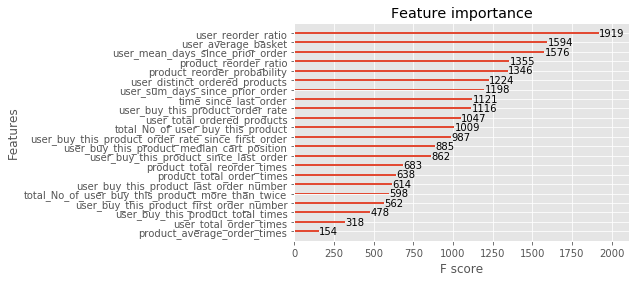

In [68]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') 
xgboost.plot_importance(bst)
plt.show()

In [69]:
d_test = xgboost.DMatrix(X_test.drop(['eval_set', 'user_id', 'order_id', 'reordered', 'product_id'], axis=1))

In [70]:
result = bst.predict(d_test)

In [71]:
p =0.2

In [72]:
result > p

array([ True,  True, False, ...,  True,  True,  True], dtype=bool)

In [73]:
X_test.loc[:,'reordered'] = (result > p).astype(int)
print X_test.shape
X_test.head()

(4833292, 27)


,user_id,product_id,user_buy_this_product_median_cart_position,user_buy_this_product_last_order_number,user_buy_this_product_total_times,user_buy_this_product_first_order_number,total_No_of_user_buy_this_product,total_No_of_user_buy_this_product_more_than_twice,product_total_order_times,product_total_reorder_times,...,user_distinct_ordered_products,user_reorder_ratio,user_average_basket,order_id,eval_set,time_since_last_order,user_buy_this_product_order_rate,user_buy_this_product_since_last_order,user_buy_this_product_order_rate_since_first_order,reordered
18,15,196,1.0,22,5,15,8000,4660,35791,27791.0,...,13,0.867647,3.272727,2161313,test,7.0,0.227273,0,0.625000,1
19,15,12427,2.0,20,10,1,1679,889,6476,4797.0,...,13,0.867647,3.272727,2161313,test,7.0,0.454545,2,0.454545,1
20,15,1747,3.5,19,4,8,562,221,1448,886.0,...,13,0.867647,3.272727,2161313,test,7.0,0.181818,3,0.266667,0
21,15,10441,2.5,22,8,1,867,465,2909,2042.0,...,13,0.867647,3.272727,2161313,test,7.0,0.363636,0,0.363636,1
22,15,11266,1.0,19,10,1,1081,645,4081,3000.0,...,13,0.867647,3.272727,2161313,test,7.0,0.454545,3,0.454545,1


In [74]:
X_test.loc[:, 'product_id'] = X_test.product_id.astype(str)
print X_test.shape
X_test.head()

(4833292, 27)


,user_id,product_id,user_buy_this_product_median_cart_position,user_buy_this_product_last_order_number,user_buy_this_product_total_times,user_buy_this_product_first_order_number,total_No_of_user_buy_this_product,total_No_of_user_buy_this_product_more_than_twice,product_total_order_times,product_total_reorder_times,...,user_distinct_ordered_products,user_reorder_ratio,user_average_basket,order_id,eval_set,time_since_last_order,user_buy_this_product_order_rate,user_buy_this_product_since_last_order,user_buy_this_product_order_rate_since_first_order,reordered
18,15,196,1.0,22,5,15,8000,4660,35791,27791.0,...,13,0.867647,3.272727,2161313,test,7.0,0.227273,0,0.625000,1
19,15,12427,2.0,20,10,1,1679,889,6476,4797.0,...,13,0.867647,3.272727,2161313,test,7.0,0.454545,2,0.454545,1
20,15,1747,3.5,19,4,8,562,221,1448,886.0,...,13,0.867647,3.272727,2161313,test,7.0,0.181818,3,0.266667,0
21,15,10441,2.5,22,8,1,867,465,2909,2042.0,...,13,0.867647,3.272727,2161313,test,7.0,0.363636,0,0.363636,1
22,15,11266,1.0,19,10,1,1081,645,4081,3000.0,...,13,0.867647,3.272727,2161313,test,7.0,0.454545,3,0.454545,1


In [75]:
df_new4 = X_test[X_test.reordered == 1].copy()

In [76]:
print df_new4.shape
df_new4.head()

(665697, 27)


,user_id,product_id,user_buy_this_product_median_cart_position,user_buy_this_product_last_order_number,user_buy_this_product_total_times,user_buy_this_product_first_order_number,total_No_of_user_buy_this_product,total_No_of_user_buy_this_product_more_than_twice,product_total_order_times,product_total_reorder_times,...,user_distinct_ordered_products,user_reorder_ratio,user_average_basket,order_id,eval_set,time_since_last_order,user_buy_this_product_order_rate,user_buy_this_product_since_last_order,user_buy_this_product_order_rate_since_first_order,reordered
18,15,196,1.0,22,5,15,8000,4660,35791,27791.0,...,13,0.867647,3.272727,2161313,test,7.0,0.227273,0,0.625000,1
19,15,12427,2.0,20,10,1,1679,889,6476,4797.0,...,13,0.867647,3.272727,2161313,test,7.0,0.454545,2,0.454545,1
21,15,10441,2.5,22,8,1,867,465,2909,2042.0,...,13,0.867647,3.272727,2161313,test,7.0,0.363636,0,0.363636,1
22,15,11266,1.0,19,10,1,1081,645,4081,3000.0,...,13,0.867647,3.272727,2161313,test,7.0,0.454545,3,0.454545,1
23,15,14715,3.0,20,11,1,3125,1411,8848,5723.0,...,13,0.867647,3.272727,2161313,test,7.0,0.500000,2,0.500000,1


In [77]:
submit = df_new4.groupby('order_id')['product_id'].agg(lambda x: ' '.join(set(x))).reset_index()
print submit.shape
submit.head()

(71683, 2)


,order_id,product_id
0,17,21463 39275 13107
1,34,2596 47792 44663 21137 39475 39180 16083 43504...
2,137,23794 2326 38689 41787 25890 24852 5134
3,182,47672 9337 47209 13629 39275 11520 33000 32109...
4,257,27104 45013 22035 24838 13870 4605 30233 21137...


In [78]:
output = sample_submission[['order_id']].merge(submit, how='left').fillna('None')
output.columns = sample_submission.columns.tolist()
print output.shape
output.head()

(75000, 2)


,order_id,products
0,17,21463 39275 13107
1,34,2596 47792 44663 21137 39475 39180 16083 43504...
2,137,23794 2326 38689 41787 25890 24852 5134
3,182,47672 9337 47209 13629 39275 11520 33000 32109...
4,257,27104 45013 22035 24838 13870 4605 30233 21137...


In [79]:
output.to_csv("Instacart 08-09-05.csv", index=False)
print 'Done'

Done
